In [ ]:
!git clone https://github.com/deepanshudashora/custom_models.git

In [ ]:
!pip3 install pytorch_lightning torch_lr_finder lightning==2.0.1

In [1]:
cd /kaggle/working/custom_models/YOLOv3/

/kaggle/working/custom_models/YOLOv3


In [2]:
!cp /kaggle/input/config8/config.py /kaggle/working/custom_models/YOLOv3

In [3]:
import config
from custom_models.YOLOv3.utils import get_loaders

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.optim as optim
from tqdm.autonotebook import tqdm
import pandas as pd
from custom_models.YOLOv3.loss import YoloLoss
loss_fn = YoloLoss()
from IPython.core.display import display
import seaborn as sn
from custom_models.YOLOv3.model import YOLOv3
from custom_models.YOLOv3.dataset import YOLODataModule
from custom_models.YOLOv3.main import YOLOTraining,check_accuracy,make_trainer
from custom_models.YOLOv3.utils import find_max_lr, criterion,check_class_accuracy,get_evaluation_bboxes,mean_average_precision
import os
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
print("/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/" + "train.csv")
train_loader, test_loader, train_eval_loader, test_data = get_loaders(
    train_csv_path="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/"+ "train.csv", test_csv_path="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/" + "test.csv"
)

/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv


In [5]:
# Define your arguments
import config
loss_fn = YoloLoss()
model = YOLOv3(num_classes=20)
max_lr = 1
train_loader = ...  # Define your train loader
pct_start = 5/40

# Create the module using the same arguments
module = YOLOTraining(loss_fn, config, model, max_lr, train_loader, pct_start)

# Load the checkpoint
loaded_class = module.load_from_checkpoint(
    checkpoint_path="/kaggle/input/trained-weights/tf_logs/lightning_logs/version_0/checkpoints/epoch=39-step=20720.ckpt",
    loss_fn=loss_fn,
    config=config,
    model=model,
    max_lr=max_lr,
    train_loader=train_loader,
    pct_start=pct_start,
    map_location="cuda"
)

In [6]:
# Get the state dict from the Lightning model
state_dict = loaded_class.model.state_dict()

# Save the state dict as weights
torch.save(state_dict, "model_weights_trained_new.pth")

In [7]:
num_classes = 20
model = YOLOv3(num_classes=num_classes)
model.load_state_dict(torch.load("model_weights_trained_new.pth"))

<All keys matched successfully>

In [8]:
model.to("cuda")
import config

check_class_accuracy(model, test_loader, threshold=0.02)

100%|██████████| 310/310 [02:03<00:00,  2.51it/s]

Class accuracy is: 85.015236%
No obj accuracy is: 98.522491%
Obj accuracy is: 65.760597%


In [9]:
import config
pred_boxes, true_boxes = get_evaluation_bboxes(
    test_loader,
    model,
    iou_threshold=0.5,
    anchors=config.ANCHORS,
    threshold=0.02,
)
mapval = mean_average_precision(
    pred_boxes,
    true_boxes,
    iou_threshold=config.MAP_IOU_THRESH,
    box_format="midpoint",
    num_classes=config.NUM_CLASSES,
)
print(f"MAP: {mapval.item()}")

100%|██████████| 310/310 [17:09<00:00,  3.32s/it]


MAP: 0.4661380648612976


,lr-Adam,train_loss,val_loss
epoch,,,
NaN,0.000136,NaN,NaN
0.0,NaN,23.571321,NaN
NaN,0.000136,NaN,NaN
0.0,NaN,18.126102,NaN
NaN,0.000136,NaN,NaN


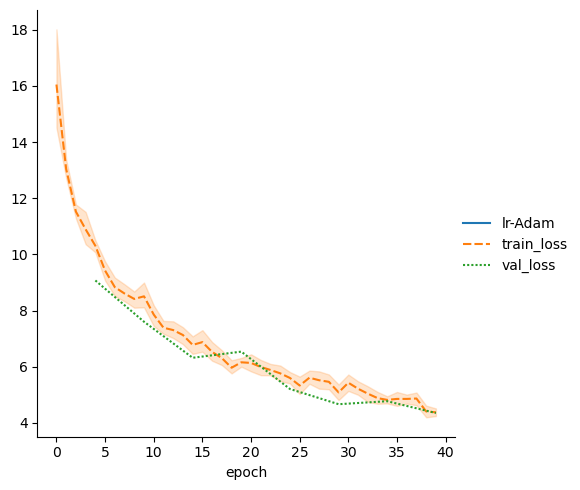

In [12]:
def evaluate_performace(csv_log_file_path):
    metrics = pd.read_csv(csv_log_file_path)
    del metrics["step"]
    metrics.set_index("epoch", inplace=True)
    display(metrics.dropna(axis=1, how="all").head())
    sn.relplot(data=metrics, kind="line")
    
evaluate_performace('/kaggle/input/trained-weights/csv_training_logs/lightning_logs/version_0/metrics.csv')